In [1]:
import tensorflow as tf
#tensorflow_hub import 수행. 
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.8.0


In [3]:
!nvidia-smi

Sat Mar 12 06:58:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 입력 이미지로 사용될 이미지 다운로드

In [4]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-03-12 06:59:11--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2022-03-12 06:59:12 (15.1 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



### TF Hub에서 EfficientDet d0 Inference 모델 다운로드 후 Inference 수행.
* 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드 후 tensorflow로 사용 가능할 수 있도록 로딩됨
* EfficientDet Tensorflow Object Detection API로 구현된 모델로 Download
* 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요.

In [5]:
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector_model = hub.load(module_handle)

In [6]:
import cv2
import time
import numpy as np

img_array_np = cv2.imread('/content/data/beatles01.jpg')
img_array = img_array_np[np.newaxis, ...] # img는 4차원이 되어야 함. 4차원으로 만들기
print(img_array_np.shape, img_array.shape)

start_time = time.time()

# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)

(633, 806, 3) (1, 633, 806, 3)
elapsed time: 14.477264642715454


In [7]:
# EfficientDet에 호환되는 데이터 타입으로 변경
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis, ...]
start_time = time.time()

# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.15463709831237793


123ms

In [9]:
# image를 numpy가 아니라 tensor로 로딩
def load_img(path):
  img = tf.io.read_file(path)
  
  #png 파일일 경우 decode_png()호출 
  img = tf.image.decode_jpeg(img, channels=3)
  print(img.shape, type(img))
  return img

In [10]:
import time 

# image를 tensor형태로 로딩. 
img = load_img('/content/data/beatles01.jpg')

# 3차원 image tensor를 4차원 tensor로 변환. 
# Efficientdet d0의 경우에는 입력 image를 unit8로 적용 필요. 
converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

start_time = time.time()

# image를 detector_model에 인자로 입력하여 inference 수행. 
result = detector_model(converted_img)
print('elapsed time:', time.time()-start_time)


(633, 806, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
elapsed time: 0.27777600288391113


### inference 수행 반환값 확인 
* inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음. 
* inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 **ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요**

In [11]:
# inference 결과 출력. ""dictionary""" 형태의 출력 결과. dict내부의 key는 model별로 서로 다름. 출력하여 key값 확인 필요. 
print(result)

{'num_detections': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>, 'detection_scores': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.94711405, 0.9359741 , 0.930035  , 0.89914006, 0.6255411 ,
        0.48422304, 0.34820274, 0.31519043, 0.31252146, 0.30964756,
        0.2892261 , 0.26785743, 0.26200387, 0.25446662, 0.24920431,
        0.24709307, 0.22555457, 0.22262326, 0.2014482 , 0.19892706,
        0.19818702, 0.19184764, 0.18933025, 0.18806435, 0.1725392 ,
        0.16980886, 0.16840705, 0.16792464, 0.16733862, 0.16649987,
        0.16592251, 0.1640691 , 0.15594028, 0.14497948, 0.144825  ,
        0.14451703, 0.14210099, 0.1397609 , 0.13904275, 0.13897413,
        0.13756542, 0.13691264, 0.13502952, 0.13211066, 0.13042402,
        0.12915248, 0.12603027, 0.12460897, 0.12447884, 0.12250272,
        0.12192424, 0.12113385, 0.12100708, 0.11963256, 0.11917201,
        0.11773316, 0.1164617 , 0.11581548, 0.11349886, 0.1134092 ,
        0.11095149,

In [12]:
print(result.keys())

# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위, num_detections는 100) 
print(result['detection_boxes'].shape, result['detection_classes'].shape,  result['detection_scores'].shape, result['num_detections'])

dict_keys(['num_detections', 'detection_scores', 'raw_detection_scores', 'raw_detection_boxes', 'detection_boxes', 'detection_multiclass_scores', 'detection_anchor_indices', 'detection_classes'])
(1, 100, 4) (1, 100) (1, 100) tf.Tensor([100.], shape=(1,), dtype=float32)


result['detection_boxes']
- 1 : img의 개수
- 100 : detect한 obj의 개수
- 4 : 좌표값    
     
result['detection_classes']
- 1 : img의 개수
- 100 : detect한 obj의 클래스    
이것포함 나머지의 값들도 tensor여서 나머지도 numpy로 변환함

In [13]:
# detect된 object들은 detection score가 "높은 순"으로 array값을 순차적으로 채움. 
print('#### detection_classes #####')
print(result['detection_classes'])

print('#### detection_scores #####')
print(result['detection_scores'])

#### detection_classes #####
tf.Tensor(
[[ 1.  1.  1.  1.  3.  3.  8. 41.  3.  3.  3.  3.  3. 41.  8.  3.  3.  3.
   3. 31. 31.  3.  3.  3.  3.  3.  3.  3. 31.  3.  3.  3.  3.  1.  3. 10.
   3.  3.  3. 31. 15. 32. 10.  3. 10.  1. 10.  3.  3.  3. 31.  1. 27. 10.
  33.  8.  3.  1. 31. 10.  3.  8.  3.  1.  3.  1.  3.  3.  3.  3.  3. 32.
   3.  1.  1. 31.  3. 31.  1.  3. 31. 10.  8.  3.  3. 32.  1.  1.  3. 10.
  41. 31.  1. 31. 10.  3.  3. 32. 31.  3.]], shape=(1, 100), dtype=float32)
#### detection_scores #####
tf.Tensor(
[[0.94711405 0.9359741  0.930035   0.89914006 0.6255411  0.48422304
  0.34820274 0.31519043 0.31252146 0.30964756 0.2892261  0.26785743
  0.26200387 0.25446662 0.24920431 0.24709307 0.22555457 0.22262326
  0.2014482  0.19892706 0.19818702 0.19184764 0.18933025 0.18806435
  0.1725392  0.16980886 0.16840705 0.16792464 0.16733862 0.16649987
  0.16592251 0.1640691  0.15594028 0.14497948 0.144825   0.14451703
  0.14210099 0.1397609  0.13904275 0.13897413 0.13756542 0.13691264

In [19]:
# bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함. 
# 좌표 값은 원본 이미지의 width, height로 0~1 사이값으로 정규화됨. --> 나중에 이걸 원본 좌표값으로 변환하려면 원본 이미지 사이즈 곱함
print('#### detection_boxes #####')
print(result['detection_boxes'].shape)
print(result['detection_boxes'])

#### detection_boxes #####
(1, 100, 4)
tf.Tensor(
[[[4.1179040e-01 6.3390404e-02 8.8111836e-01 2.6741692e-01]
  [4.3304449e-01 4.7706345e-01 8.9250046e-01 6.8628883e-01]
  [4.1960636e-01 6.8270773e-01 8.9688581e-01 8.9498097e-01]
  [4.1164526e-01 2.6410931e-01 8.6583102e-01 4.6428424e-01]
  [3.8654572e-01 1.7934971e-01 5.4316032e-01 3.2028842e-01]
  [3.6050096e-01 6.2638736e-01 4.6446508e-01 7.1950281e-01]
  [3.5996157e-01 6.2458235e-01 4.6350211e-01 7.2000319e-01]
  [7.1983784e-01 6.2759423e-01 8.6870378e-01 7.0305586e-01]
  [3.6646506e-01 3.8801342e-01 4.2244112e-01 4.3741155e-01]
  [3.5229647e-01 5.4654634e-01 3.8833630e-01 5.7694817e-01]
  [3.6912179e-01 5.8222091e-01 4.1025555e-01 6.2288415e-01]
  [3.7102419e-01 5.9425956e-01 4.3720052e-01 6.3780028e-01]
  [3.5444003e-01 4.7450614e-01 3.8303304e-01 4.9580967e-01]
  [7.1531910e-01 5.7743710e-01 8.7339032e-01 6.8964785e-01]
  [3.8982463e-01 1.7769308e-01 5.3870612e-01 3.1275189e-01]
  [3.5579172e-01 5.5832678e-01 3.9027628e-01 5.862

### inference 결과를 이미지로 시각화

In [20]:
result.items()

dict_items([('num_detections', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>), ('detection_scores', <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.94711405, 0.9359741 , 0.930035  , 0.89914006, 0.6255411 ,
        0.48422304, 0.34820274, 0.31519043, 0.31252146, 0.30964756,
        0.2892261 , 0.26785743, 0.26200387, 0.25446662, 0.24920431,
        0.24709307, 0.22555457, 0.22262326, 0.2014482 , 0.19892706,
        0.19818702, 0.19184764, 0.18933025, 0.18806435, 0.1725392 ,
        0.16980886, 0.16840705, 0.16792464, 0.16733862, 0.16649987,
        0.16592251, 0.1640691 , 0.15594028, 0.14497948, 0.144825  ,
        0.14451703, 0.14210099, 0.1397609 , 0.13904275, 0.13897413,
        0.13756542, 0.13691264, 0.13502952, 0.13211066, 0.13042402,
        0.12915248, 0.12603027, 0.12460897, 0.12447884, 0.12250272,
        0.12192424, 0.12113385, 0.12100708, 0.11963256, 0.11917201,
        0.11773316, 0.1164617 , 0.11581548, 0.11349886, 0.1134092 ,
     

In [21]:
# result내의 value들을 모두 numpy로 변환. 
result = {key:value.numpy() for key,value in result.items()} # items을 하면 key와 value가 하나씩 변환됨

In [22]:
# 1부터 91까지의 COCO Class id 매핑. 
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [23]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_detector()

In [ ]:
min()

In [38]:
result['detection_scores'][0].shape[0]

100

person: 0.9484
person: 0.9401
person: 0.9359
person: 0.8954
car: 0.6267
car: 0.5109
truck: 0.3303
car: 0.3149


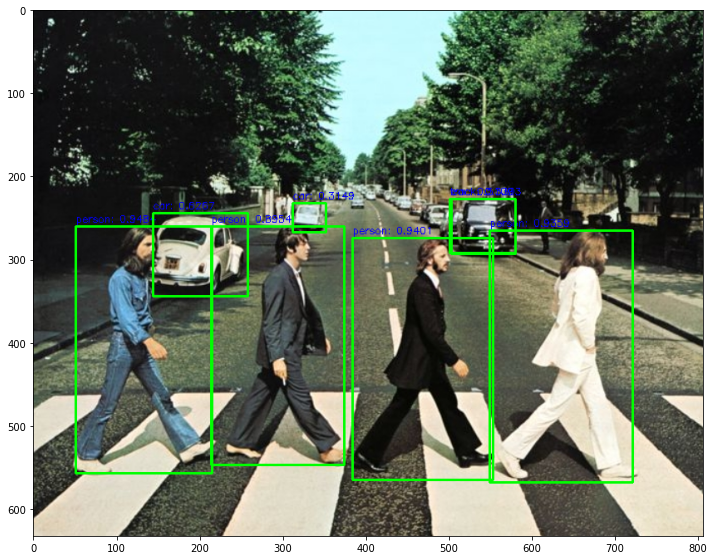

In [39]:
import cv2

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

# pretrained 모델을 다운로드 한 뒤 inference 수행. 
result = detector_model(img_tensor)

# result 내부의 value를 numpy 로 변환. 
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.3
OBJECT_DEFAULT_COUNT = 100 # 수동으로도 줄일 수 있음

# detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):

  # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
  score = result['detection_scores'][0, i] # 0 : img 0번 (현재 img가 1개밖에 없으니깐) / i : i의 끝까지 순차적으로 튀어나오게 됨
  if score < SCORE_THRESHOLD:
    break # 높은 순으로 정렬이 돼있기 때문에 continue로 끝까지 갈 필요는 없음

  # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
  box = result['detection_boxes'][0, i]

  ''' **** 주의 ******
   box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  # class id 추출하고 class 명으로 매핑
  class_id = result['detection_classes'][0, i] # 개별 obj별로 값들을 추출하고 
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)

  # 시각화
  # cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [40]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   

  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]

  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet모델로 inference 수행. 
  start_time = time.time()

  # inference 결과로 내부 원소가 Tensor이 Dict 반환 
  result = model(img_tensor)

  # result 내부의 value를 numpy 로 변환. 
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):

    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break

    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9484
person: 0.9401
person: 0.9359
person: 0.8954
car: 0.6267
car: 0.5109
Detection 수행시간: 0.16 초


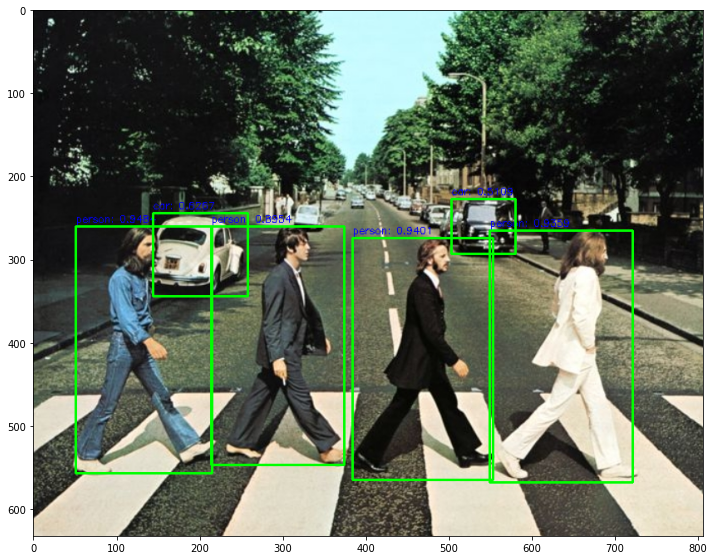

In [41]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [42]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2022-03-12 08:05:26--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.007s  

2022-03-12 08:05:26 (9.79 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



person: 0.9570
person: 0.9252
person: 0.9068
baseball glove: 0.6338
baseball bat: 0.5929
Detection 수행시간: 0.15 초


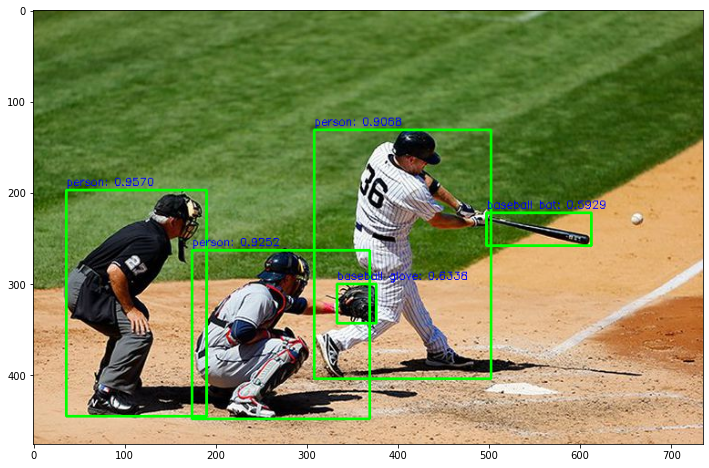

In [43]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### EfficientDet D2 모델로 Inference 수행. 

In [44]:
detector_model_d2 = get_detector('https://tfhub.dev/tensorflow/efficientdet/d2/1')

person: 0.9488
person: 0.9321
person: 0.8895
baseball glove: 0.8303
baseball bat: 0.6166
sports ball: 0.5037
Detection 수행시간: 6.37 초


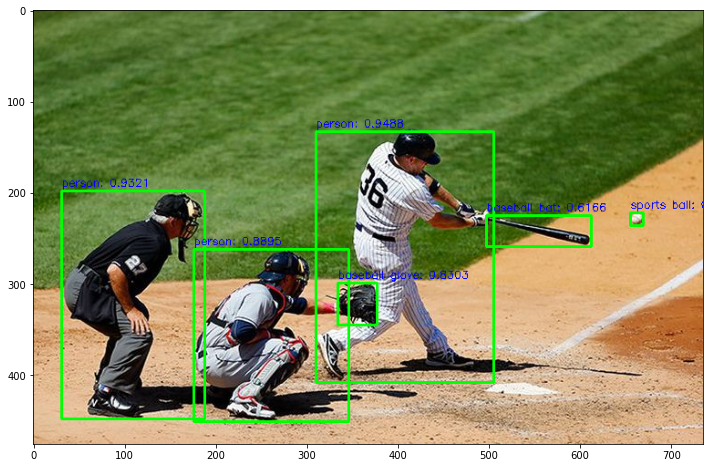

In [45]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### Video Inference 수행

In [50]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2022-03-12 08:09:38--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-03-12 08:09:38--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-03-12 08:09:38--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [52]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [53]:
do_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.7054
car: 0.6741
car: 0.6634
car: 0.6490
Detection 수행시간: 0.18 초
car: 0.7121
car: 0.6782
car: 0.6640
car: 0.6493
Detection 수행시간: 0.16 초
car: 0.6018
motorcycle: 0.5719
car: 0.5339
person: 0.5157
car: 0.5006
person: 0.5002
Detection 수행시간: 0.16 초
motorcycle: 0.5697
car: 0.5522
car: 0.5182
person: 0.5053
Detection 수행시간: 0.16 초
car: 0.6813
motorcycle: 0.5480
car: 0.5432
person: 0.5387
Detection 수행시간: 0.16 초
car: 0.6372
motorcycle: 0.5610
car: 0.5422
Detection 수행시간: 0.16 초
car: 0.6398
motorcycle: 0.5655
car: 0.5501
car: 0.5255
Detection 수행시간: 0.15 초
car: 0.7404
car: 0.7017
car: 0.6398
motorcycle: 0.5679
person: 0.5268
Detection 수행시간: 0.15 초
car: 0.6955
car: 0.6933
car: 0.6458
motorcycle: 0.5257
Detection 수행시간: 0.15 초
car: 0.7060
car: 0.6844
car: 0.6742
motorcycle: 0.5419
Detection 수행시간: 0.16 초
car: 0.7386
car: 0.6630
car: 0.6616
motorcycle: 0.5867
Detection 수행시간: 0.15 초
car: 0.7788
car: 0.7119
car: 0.6659
motorcycle: 0.5716
Detection 수행시간: 0.15 초
car: 0.7903
person: 0.67

### EfficientDet lite0 Pretrained 모델 Inference 수행
* EfficientDet Lite는 automl 패키지로 구현됨. 
* 입력 이미지로 numpy array, tensor 모두 가능, type은 unit8 필요. 
* inference 결과로 box정보, score정보, class 정보를 각각 Tensor로 반환. 

In [55]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np

detector_automl_lite0 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite0/detection/1")

In [56]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
#img_array_01 = img_array[np.newaxis, ...]

img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

start_time = time.time()

# image를 detector_model에 인자로 입력하여 inference 수행. 
#boxes, scores, classes, num_detections = detector_automl_lite0(img_array_01)
boxes, scores, classes, num_detections = detector_automl_lite0(img_tensor)

print('elapsed time:', time.time()-start_time)

elapsed time: 2.1798505783081055


In [58]:
boxes.shape, scores.shape, classes.shape, num_detections # valid한 detection 결과를 가지고 있음

(TensorShape([1, 100, 4]),
 TensorShape([1, 100]),
 TensorShape([1, 100]),
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([100], dtype=int32)>)

In [59]:
#좌표값이 0~1사이로 정규화 되지 않고 원본 이미지의 좌표값으로 반환 
print('원본 이미지 shape:', img_array.shape)

# 여기서 첫 번째 인자의 0은 첫 번째 이미지
boxes[0, 0:10], scores[0, :10], classes[0, :10]

원본 이미지 shape: (476, 735, 3)


(<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
 array([[202.11865 ,  31.700203, 445.80273 , 188.72594 ],
        [259.24213 , 174.63013 , 455.48645 , 373.06177 ],
        [127.93706 , 324.82584 , 407.09464 , 493.36212 ],
        [300.97815 , 331.1551  , 344.10986 , 374.19156 ],
        [236.80632 , 542.42914 , 261.38422 , 609.6119  ],
        [222.16089 , 659.98816 , 236.1999  , 678.62085 ],
        [227.95496 , 496.07425 , 263.47733 , 610.33655 ],
        [223.7558  , 647.2287  , 238.00728 , 661.4642  ],
        [218.31972 , 654.4792  , 226.83658 , 662.96124 ],
        [220.97037 , 494.3057  , 246.90009 , 588.9908  ]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.90091765, 0.8834344 , 0.8455462 , 0.4854285 , 0.38026473,
        0.2700993 , 0.26304004, 0.25670242, 0.17502265, 0.1738919 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 1.,  1.,  1., 40., 39., 37., 39., 37., 37., 39.], dtype=float32)>)

In [60]:
# COCO
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [61]:
def get_detected_img_automl(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()


  # ★★ automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. ★★ 
  boxes, scores, classes, num_detections = model(img_tensor)


  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  num_detections = num_detections.numpy()
  

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(num_detections[0]): # 100이 추출됨

    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    if score < score_threshold:
      break

    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)

    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9009
person: 0.8834
person: 0.8455
baseball glove: 0.4854
baseball bat: 0.3803
Detection 수행시간: 0.03 초


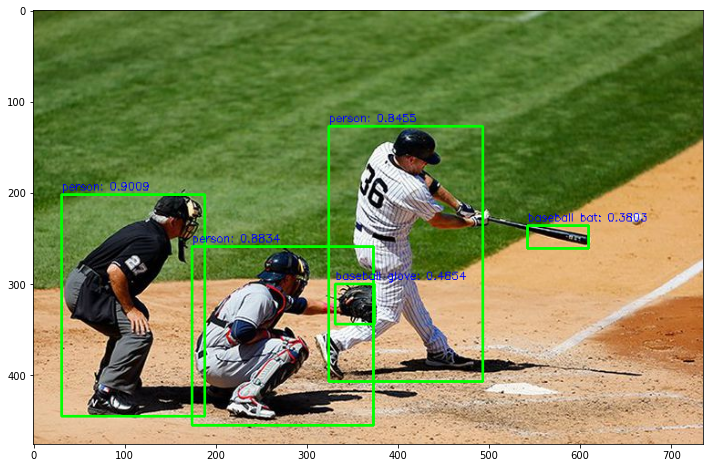

In [62]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img_automl(detector_automl_lite0, img_array, score_threshold=0.3, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

person: 0.8218
person: 0.8134
person: 0.7396
person: 0.6831
car: 0.6212
car: 0.4215
car: 0.3183
Detection 수행시간: 1.74 초


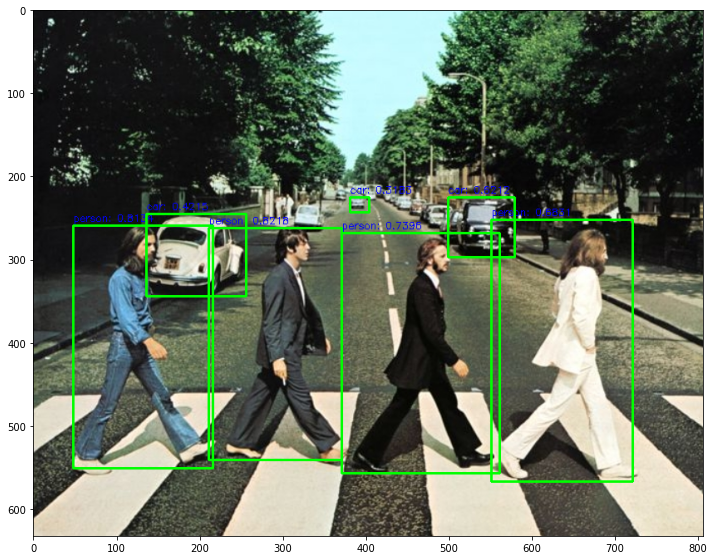

In [63]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
draw_img = get_detected_img_automl(detector_automl_lite0, img_array, score_threshold=0.3, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### EfficientDet lite2 모델로 inference 수행.

In [64]:
detector_automl_lite2 = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

person: 0.9152
person: 0.9089
person: 0.8914
person: 0.8808
car: 0.6071
car: 0.5114
Detection 수행시간: 0.04 초


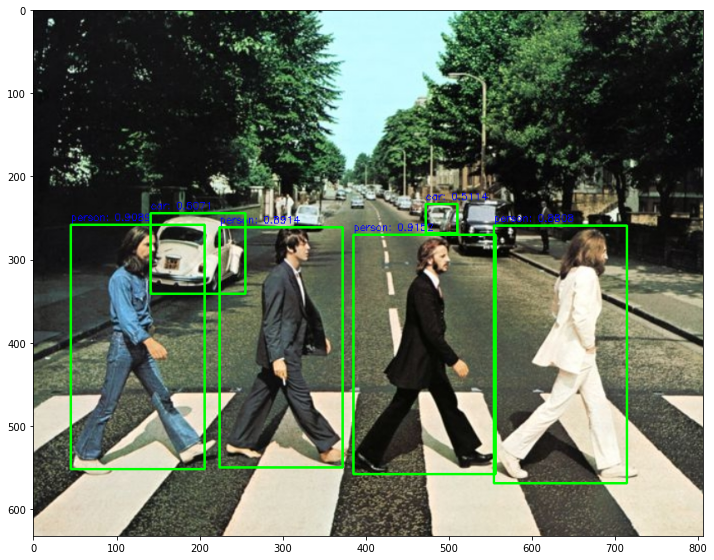

In [66]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

draw_img = get_detected_img_automl(detector_automl_lite2, img_array, score_threshold=0.5, object_show_count=100, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [67]:
def do_detected_video_automl(model, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        # get_detected_img_automl() 호출 
        img_frame = get_detected_img_automl(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)
        
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [68]:
do_detected_video_automl(detector_automl_lite2, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_lite_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.7213
car: 0.7048
person: 0.6839
car: 0.6667
car: 0.6558
car: 0.5763
Detection 수행시간: 2.12 초
car: 0.7208
car: 0.7070
person: 0.6858
car: 0.6600
car: 0.6558
car: 0.5790
Detection 수행시간: 0.04 초
car: 0.6072
person: 0.5958
car: 0.5877
car: 0.5727
Detection 수행시간: 0.03 초
car: 0.6773
person: 0.6331
car: 0.5557
Detection 수행시간: 0.03 초
car: 0.7090
person: 0.6330
car: 0.6061
car: 0.5067
Detection 수행시간: 0.03 초
car: 0.6947
car: 0.6896
person: 0.5417
Detection 수행시간: 0.03 초
car: 0.6893
car: 0.6833
person: 0.5335
Detection 수행시간: 0.03 초
car: 0.7336
car: 0.7109
car: 0.6813
motorcycle: 0.5120
Detection 수행시간: 0.03 초
car: 0.7302
car: 0.7150
motorcycle: 0.6327
car: 0.6062
Detection 수행시간: 0.03 초
car: 0.7211
car: 0.7191
motorcycle: 0.6324
car: 0.6052
Detection 수행시간: 0.03 초
car: 0.7077
car: 0.6678
car: 0.6344
motorcycle: 0.6321
Detection 수행시간: 0.04 초
car: 0.7145
car: 0.7095
car: 0.6083
motorcycle: 0.6038
Detection 수행시간: 0.03 초
car: 0.7381
car: 0.6946
motorcycle: 0.5520
car: 0.5499
Detection 